# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [5]:
# weather = pd.read_csv(path.joinpath('jena_climate_2009_2016.csv.zip'), 
#                       index_col='DateTime', 
#                       usecols=['DateTime','Temperature'], 
#                       parse_dates=True)

In [6]:
# daily_weather = weather.resample('D').mean()

In [7]:
# store the data set as a csv file
#daily_weather.to_csv(path.joinpath('daily_weather.csv'))

In [8]:
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)

In [9]:
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']

In [10]:
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

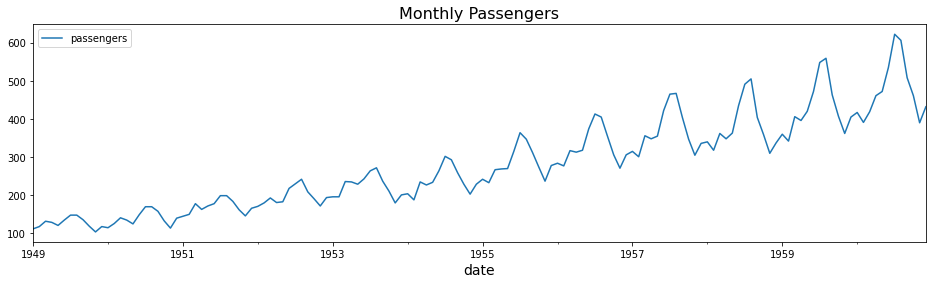

In [11]:
air.plot(title='Monthly Passengers')

<AxesSubplot:title={'center':'Avg Daily Weather Temperature in C'}, xlabel='DateTime'>

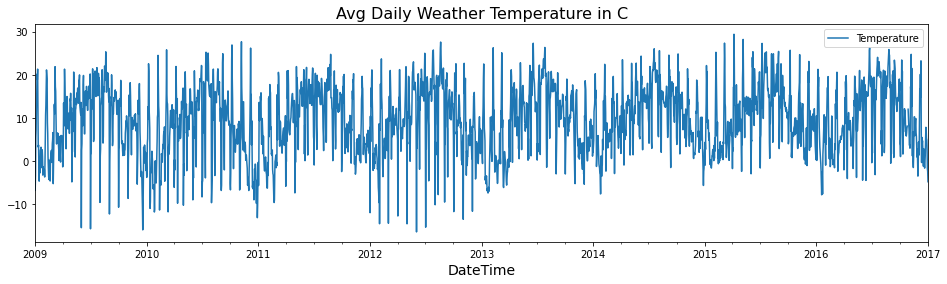

In [12]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')

<AxesSubplot:title={'center':'2012 Avg Daily Weather Temperature Pattern in C'}, xlabel='DateTime'>

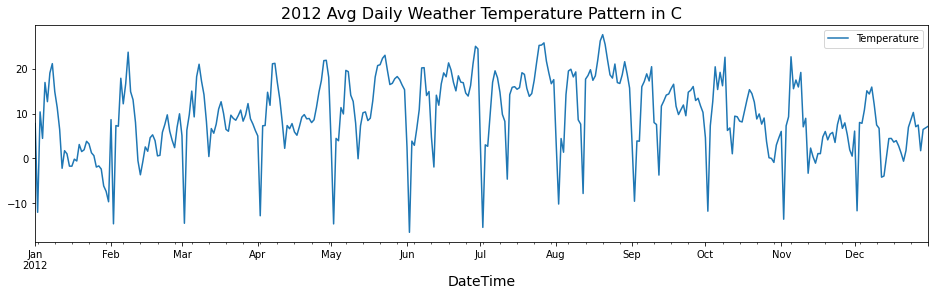

In [13]:
daily_weather.loc['2012'].plot(title='2012 Avg Daily Weather Temperature Pattern in C')

<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='Month'>

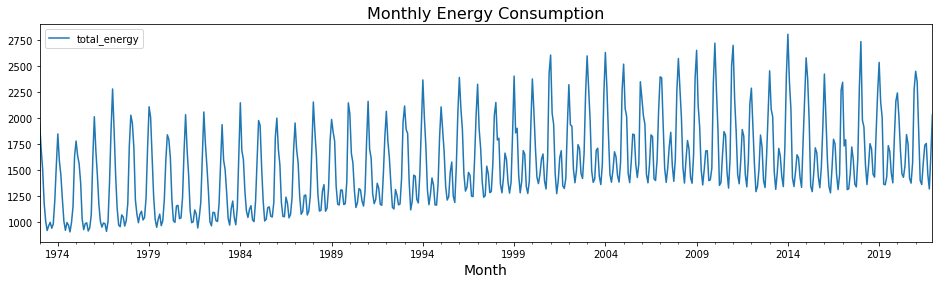

In [14]:
energy.plot(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'2012-2014 Monthly Energy Consumption Pattern'}, xlabel='Month'>

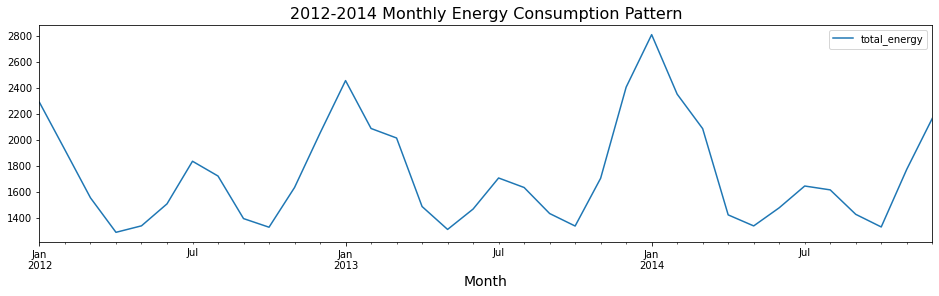

In [15]:
energy.loc['2012':'2014'].plot(title='2012-2014 Monthly Energy Consumption Pattern')

In [16]:
energy.isna().sum()

total_energy    0
dtype: int64

In [17]:
daily_weather.ffill(inplace=True)

In [18]:
daily_weather.isna().sum()

Temperature    0
dtype: int64

In [19]:
air.isna().sum()

passengers    0
dtype: int64

## Tranform the data sets
### Windowing

In [20]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [21]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

In [22]:
air_d.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [23]:
dw_d.head()

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847


In [24]:
en_d.head()

,x_1,x_2,x_3,x_4,x_5,y
Month,,,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949
1973-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872
1973-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259
1973-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083
1973-05-01,1006.326,914.949,961.872,994.259,937.083,978.162


### Scale and split data

In [25]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [26]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [27]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



In [28]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.418086,-1.335433,-1.163321,-1.213649,-1.331677,-1.193676
1949-02-28,-1.340522,-1.160959,-1.199458,-1.308609,-1.165784,-1.038787
1949-03-31,-1.159538,-1.198346,-1.295820,-1.142429,-1.011740,-1.038787
1949-04-30,-1.198320,-1.298045,-1.127185,-0.988119,-1.011740,-1.181762
1949-05-31,-1.301740,-1.123572,-0.970596,-0.988119,-1.153934,-1.384309


In [29]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


### Split into X and Y (Features and Target)

In [30]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [31]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

In [32]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

In [33]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [34]:
scale_air.inverse_y(y_train_air)[0:5]

array([[135.],
       [148.],
       [148.],
       [136.],
       [119.]])

In [35]:
x_train_air.shape

(102, 5, 1)

In [36]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(102, 1) (20, 1) (17, 1)


## There is more

In [37]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [38]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [39]:
# scale = StandardScaler()
# scale.fit(train)

In [40]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [41]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

# Forecasting with Keras

In [42]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [43]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [44]:
def train_model(model, 
                x_train, 
                y_train, 
                x_val, 
                y_val, 
                epochs=100, 
                patience=10, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       min_delta=0, 
                                       patience=patience)
    
    history = model.fit(x_train,
              y_train, 
              shuffle=False, 
              epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es],
              verbose=1)
    return history

In [45]:
def plot_forecast(model, x_test, y_test, index, history):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    pd.Series(history.history['root_mean_squared_error']).plot(ax=ax1, 
                                                               title='RMSE by EPOCH',
                                                              label='rmse')
    pd.Series(history.history['val_root_mean_squared_error']).plot(ax=ax1,
                                                                  label='val_rmse')
    plt.legend()

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    pd.Series(history.history['mean_absolute_error']).plot(ax=ax2,
                                                          title='MAE by EPOCH',
                                                          label='mae')
    pd.Series(history.history['val_mean_absolute_error']).plot(ax=ax2,
                                                              label='val_mae')
    plt.legend()
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    predicted = model.predict(x_test)
    print(predicted.shape)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax3, 
                                title='Forecast vs Actual',
                               label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax3)
    plt.legend();plt.show()


### Air Passenger

In [46]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

2022-04-22 05:56:51.077070: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [48]:
history_a_simpleRNN = train_model(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 74ms/step - loss: 0.6830 - root_mean_squared_error: 0.8264 - mean_absolute_error: 0.6554 - val_loss: 1.6181 - val_root_mean_squared_error: 1.2721 - val_mean_absolute_error: 1.0922
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.4682 - root_mean_squared_error: 0.6843 - mean_absolute_error: 0.5435 - val_loss: 1.0641 - val_root_mean_squared_error: 1.0316 - val_mean_absolute_error: 0.7950
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.2559 - root_mean_squared_error: 0.5059 - mean_absolute_error: 0.4190 - val_loss: 0.7236 - val_root_mean_squared_error: 0.8506 - val_mean_absolute_error: 0.5969
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.3079 - root_mean_squared_error: 0.5549 - mean_absolute_error: 0.4417 - val_loss: 0.5544 - val_root_mean_squared_error: 0.7446 - val_mean_absolute_error: 0.5403
Epoch 5/100
4/4 [==============================] - 0s 11ms/step -

In [49]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [50]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 20ms/step - loss: 0.7728 - root_mean_squared_error: 0.8791 - mean_absolute_error: 0.7320


[0.7728131413459778, 0.8790979385375977, 0.7319655418395996]

(20, 1)


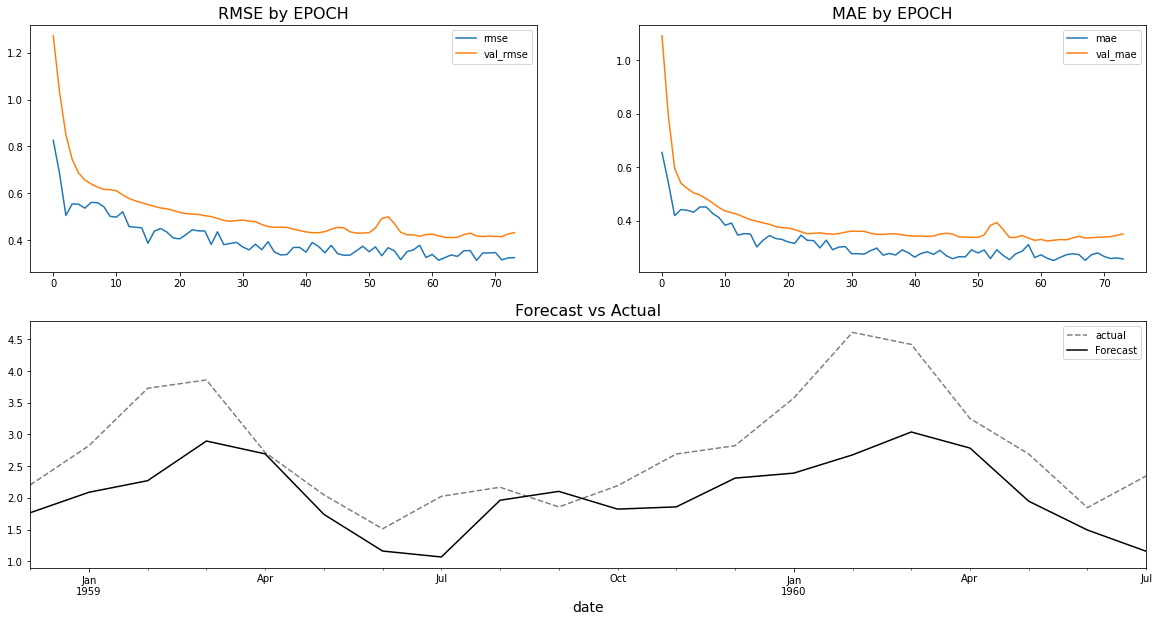

In [51]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [52]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [53]:
model_dw_simpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [54]:
history_dw_simpleRNN = train_model(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 0.4919 - root_mean_squared_error: 0.7013 - mean_absolute_error: 0.4930 - val_loss: 0.3079 - val_root_mean_squared_error: 0.5549 - val_mean_absolute_error: 0.3996
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4684 - root_mean_squared_error: 0.6844 - mean_absolute_error: 0.4842 - val_loss: 0.3119 - val_root_mean_squared_error: 0.5585 - val_mean_absolute_error: 0.4018
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4454 - root_mean_squared_error: 0.6674 - mean_absolute_error: 0.4749 - val_loss: 0.3143 - val_root_mean_squared_error: 0.5606 - val_mean_absolute_error: 0.4101
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4396 - root_mean_squared_error: 0.6631 - mean_absolute_error: 0.4717 - val_loss: 0.3143 - val_root_mean_squared_error: 0.5606 - val_mean_absolute_error: 0.4078
Epoch 5/100
33/33 [==============================] - 0s 3ms/

In [55]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

14/14 [==============================] - 0s 2ms/step - loss: 0.3579 - root_mean_squared_error: 0.5982 - mean_absolute_error: 0.4465


[0.3578642010688782, 0.5982175469398499, 0.4465080499649048]

(437, 1)


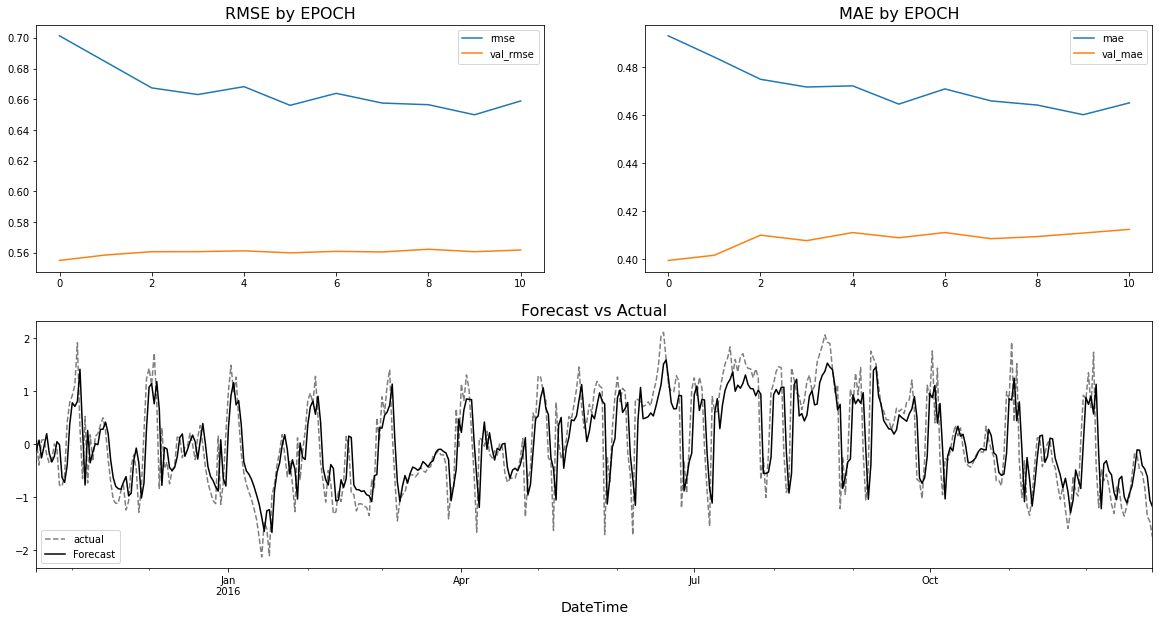

In [56]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [57]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [58]:
history_en_simpleRNN = train_model(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 1s 34ms/step - loss: 2.3552 - root_mean_squared_error: 1.5347 - mean_absolute_error: 1.2469 - val_loss: 3.2155 - val_root_mean_squared_error: 1.7932 - val_mean_absolute_error: 1.3078
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 1.7963 - root_mean_squared_error: 1.3403 - mean_absolute_error: 1.0807 - val_loss: 2.6060 - val_root_mean_squared_error: 1.6143 - val_mean_absolute_error: 1.1343
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 1.5400 - root_mean_squared_error: 1.2410 - mean_absolute_error: 1.0156 - val_loss: 2.1866 - val_root_mean_squared_error: 1.4787 - val_mean_absolute_error: 1.0435
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 1.3071 - root_mean_squared_error: 1.1433 - mean_absolute_error: 0.9387 - val_loss: 1.8834 - val_root_mean_squared_error: 1.3724 - val_mean_absolute_error: 0.9907
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - lo

In [59]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

3/3 [==============================] - 0s 3ms/step - loss: 0.2731 - root_mean_squared_error: 0.5226 - mean_absolute_error: 0.4072


[0.2730606198310852, 0.5225520133972168, 0.4072253704071045]

In [60]:
y_test_air.shape

(20, 1)

(87, 1)


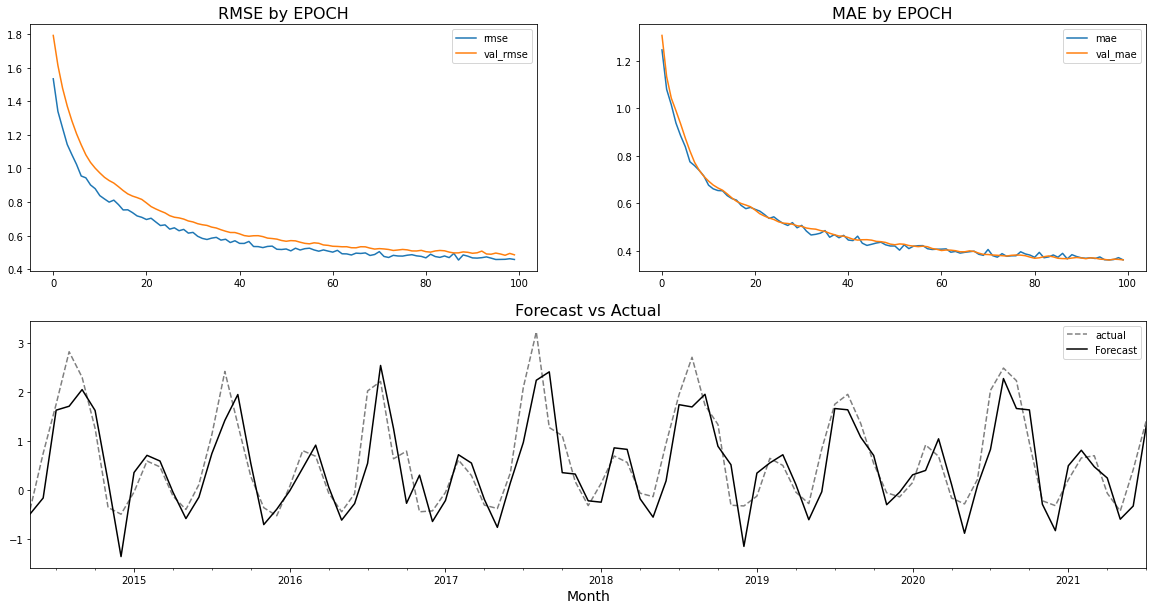

In [61]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [62]:
scale_en.inverse_y(y_test_en[0:5])

array([[1331.478],
       [1773.932],
       [2164.807],
       [2580.929],
       [2377.381]])

In [63]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

array([[1293.3263],
       [1419.4205],
       [2116.8477],
       [2147.998 ],
       [2280.2808]], dtype=float32)

## LSTM

In [64]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [65]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [66]:
history_a_lstm = train_model(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 136ms/step - loss: 1.2114 - root_mean_squared_error: 1.1006 - mean_absolute_error: 0.8994 - val_loss: 3.9575 - val_root_mean_squared_error: 1.9894 - val_mean_absolute_error: 1.8719
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 1.1361 - root_mean_squared_error: 1.0659 - mean_absolute_error: 0.8658 - val_loss: 3.6792 - val_root_mean_squared_error: 1.9181 - val_mean_absolute_error: 1.7959
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0530 - root_mean_squared_error: 1.0262 - mean_absolute_error: 0.8343 - val_loss: 3.4172 - val_root_mean_squared_error: 1.8486 - val_mean_absolute_error: 1.7212
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.9810 - root_mean_squared_error: 0.9904 - mean_absolute_error: 0.8016 - val_loss: 3.1718 - val_root_mean_squared_error: 1.7810 - val_mean_absolute_error: 1.6481
Epoch 5/100
4/4 [==============================] - 0s 15ms/step

In [67]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 26ms/step - loss: 1.1807 - root_mean_squared_error: 1.0866 - mean_absolute_error: 0.8618


[1.1807056665420532, 1.086602807044983, 0.8618272542953491]

(20, 1)


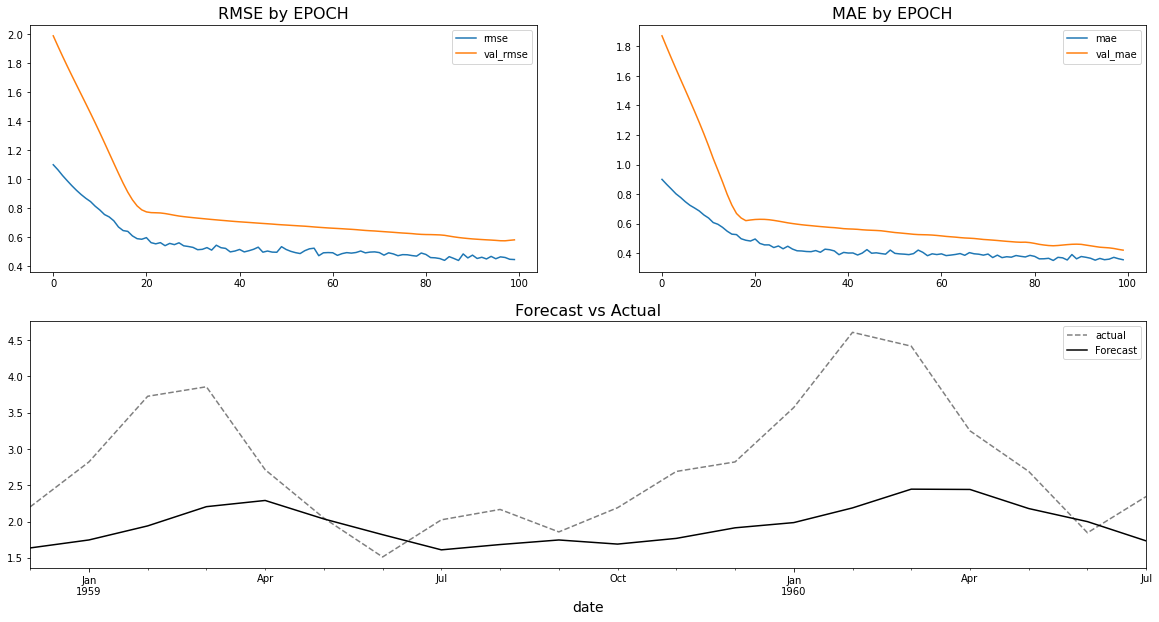

In [68]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [69]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [70]:
history_dw_lstm = train_model(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 2s 17ms/step - loss: 0.8893 - root_mean_squared_error: 0.9430 - mean_absolute_error: 0.7725 - val_loss: 0.6190 - val_root_mean_squared_error: 0.7868 - val_mean_absolute_error: 0.6174
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.7590 - root_mean_squared_error: 0.8712 - mean_absolute_error: 0.6903 - val_loss: 0.5557 - val_root_mean_squared_error: 0.7454 - val_mean_absolute_error: 0.5655
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7004 - root_mean_squared_error: 0.8369 - mean_absolute_error: 0.6524 - val_loss: 0.5138 - val_root_mean_squared_error: 0.7168 - val_mean_absolute_error: 0.5425
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6477 - root_mean_squared_error: 0.8048 - mean_absolute_error: 0.6212 - val_loss: 0.4739 - val_root_mean_squared_error: 0.6884 - val_mean_absolute_error: 0.5199
Epoch 5/100
33/33 [==============================] - 0s 5ms

(437, 1)


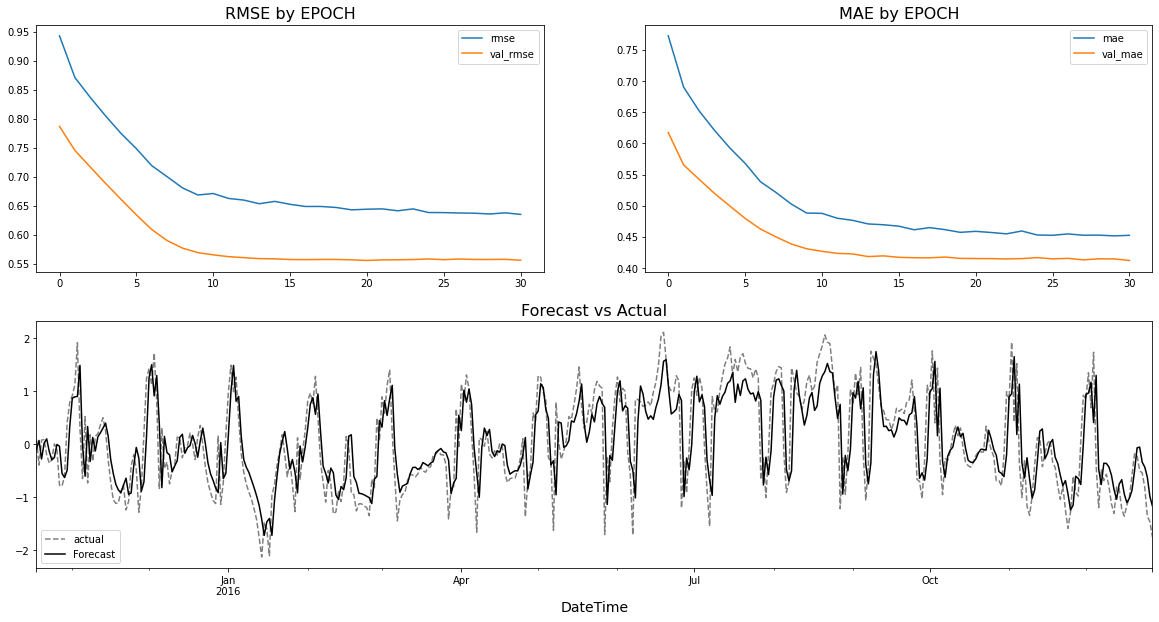

In [71]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [72]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [73]:
history_en_lstm = train_model(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 77ms/step - loss: 1.0164 - root_mean_squared_error: 1.0082 - mean_absolute_error: 0.8255 - val_loss: 1.5936 - val_root_mean_squared_error: 1.2624 - val_mean_absolute_error: 0.8807
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9785 - root_mean_squared_error: 0.9892 - mean_absolute_error: 0.8140 - val_loss: 1.5413 - val_root_mean_squared_error: 1.2415 - val_mean_absolute_error: 0.8702
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9537 - root_mean_squared_error: 0.9766 - mean_absolute_error: 0.8020 - val_loss: 1.4900 - val_root_mean_squared_error: 1.2207 - val_mean_absolute_error: 0.8614
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9383 - root_mean_squared_error: 0.9687 - mean_absolute_error: 0.8006 - val_loss: 1.4432 - val_root_mean_squared_error: 1.2013 - val_mean_absolute_error: 0.8534
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - lo

(87, 1)


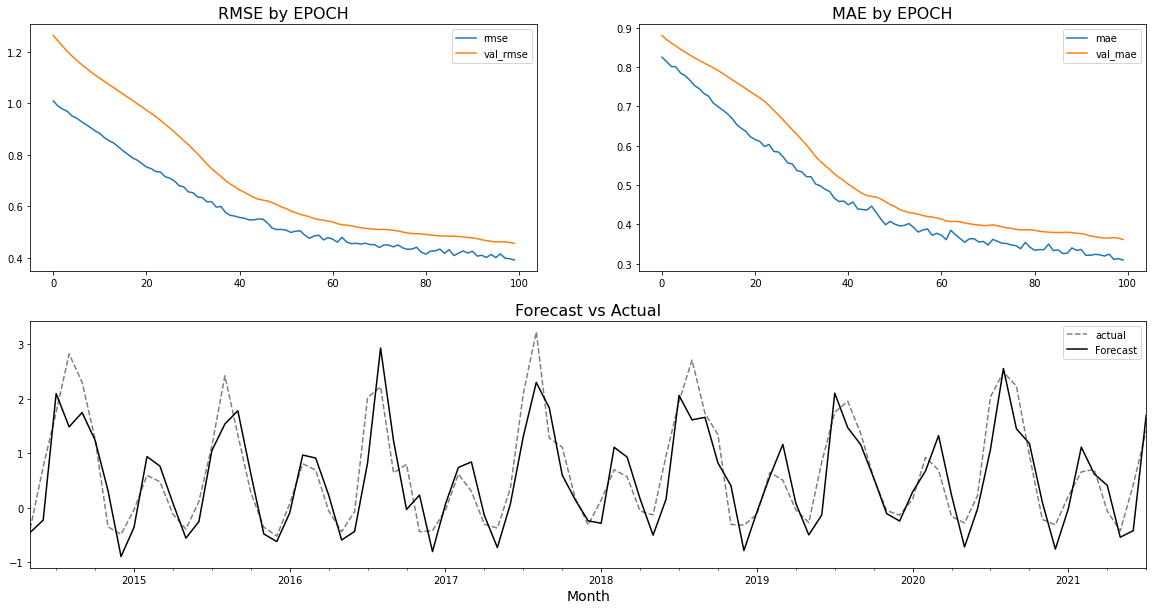

In [74]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [75]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [76]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/100
4/4 [==============================] - 2s 142ms/step - loss: 1.0047 - root_mean_squared_error: 1.0024 - mean_absolute_error: 0.8106 - val_loss: 3.1260 - val_root_mean_squared_error: 1.7681 - val_mean_absolute_error: 1.6388
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8990 - root_mean_squared_error: 0.9482 - mean_absolute_error: 0.7651 - val_loss: 2.7536 - val_root_mean_squared_error: 1.6594 - val_mean_absolute_error: 1.5224
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8130 - root_mean_squared_error: 0.9016 - mean_absolute_error: 0.7261 - val_loss: 2.4090 - val_root_mean_squared_error: 1.5521 - val_mean_absolute_error: 1.4059
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7123 - root_mean_squared_error: 0.8439 - mean_absolute_error: 0.6744 - val_loss: 2.0953 - val_root_mean_squared_error: 1.4475 - val_mean_absolute_error: 1.2906
Epoch 5/100
4/4 [==============================] - 0s 12ms/step

(20, 1)


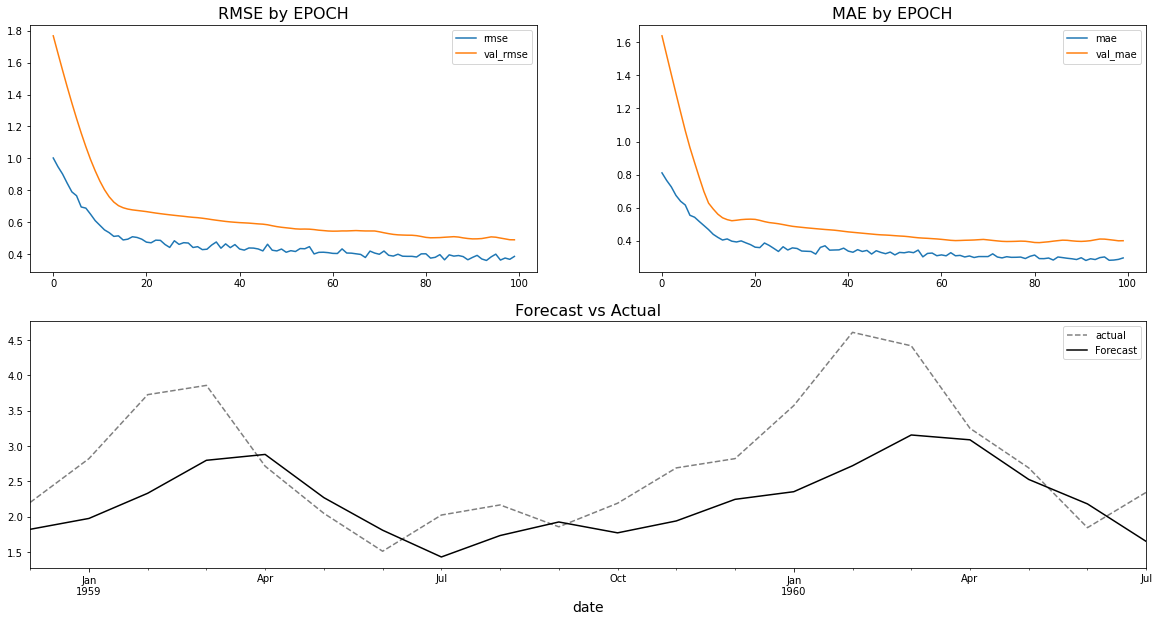

In [77]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [78]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 3s 22ms/step - loss: 0.7017 - root_mean_squared_error: 0.8377 - mean_absolute_error: 0.6659 - val_loss: 0.4520 - val_root_mean_squared_error: 0.6723 - val_mean_absolute_error: 0.5013
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.5671 - root_mean_squared_error: 0.7531 - mean_absolute_error: 0.5664 - val_loss: 0.3959 - val_root_mean_squared_error: 0.6292 - val_mean_absolute_error: 0.4660
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.5202 - root_mean_squared_error: 0.7213 - mean_absolute_error: 0.5337 - val_loss: 0.3600 - val_root_mean_squared_error: 0.6000 - val_mean_absolute_error: 0.4452
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 0.4866 - root_mean_squared_error: 0.6975 - mean_absolute_error: 0.5130 - val_loss: 0.3363 - val_root_mean_squared_error: 0.5799 - val_mean_absolute_error: 0.4318
Epoch 5/100
33/33 [==============================] - 0s 6ms

(437, 1)


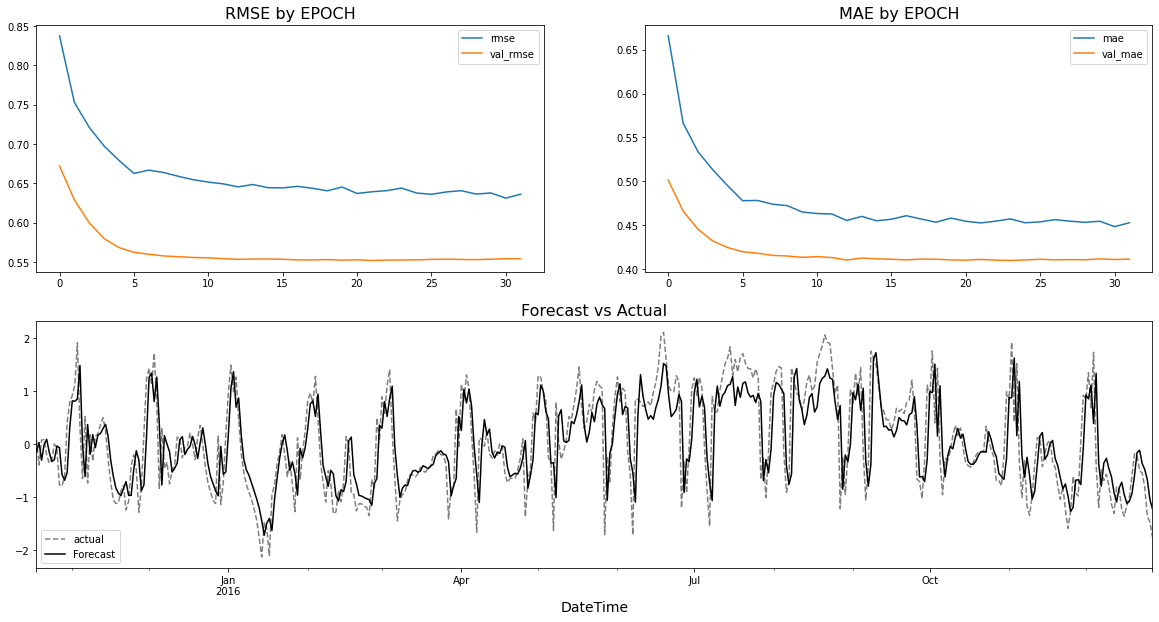

In [79]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [80]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [81]:
history_en_gru = train_model(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 3s 101ms/step - loss: 0.8272 - root_mean_squared_error: 0.9095 - mean_absolute_error: 0.7448 - val_loss: 1.2571 - val_root_mean_squared_error: 1.1212 - val_mean_absolute_error: 0.8128
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7607 - root_mean_squared_error: 0.8722 - mean_absolute_error: 0.7127 - val_loss: 1.1834 - val_root_mean_squared_error: 1.0878 - val_mean_absolute_error: 0.7963
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.7159 - root_mean_squared_error: 0.8461 - mean_absolute_error: 0.6881 - val_loss: 1.1126 - val_root_mean_squared_error: 1.0548 - val_mean_absolute_error: 0.7777
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6794 - root_mean_squared_error: 0.8243 - mean_absolute_error: 0.6714 - val_loss: 1.0491 - val_root_mean_squared_error: 1.0243 - val_mean_absolute_error: 0.7584
Epoch 5/100
7/7 [==============================] - 0s 8ms/step -

(87, 1)


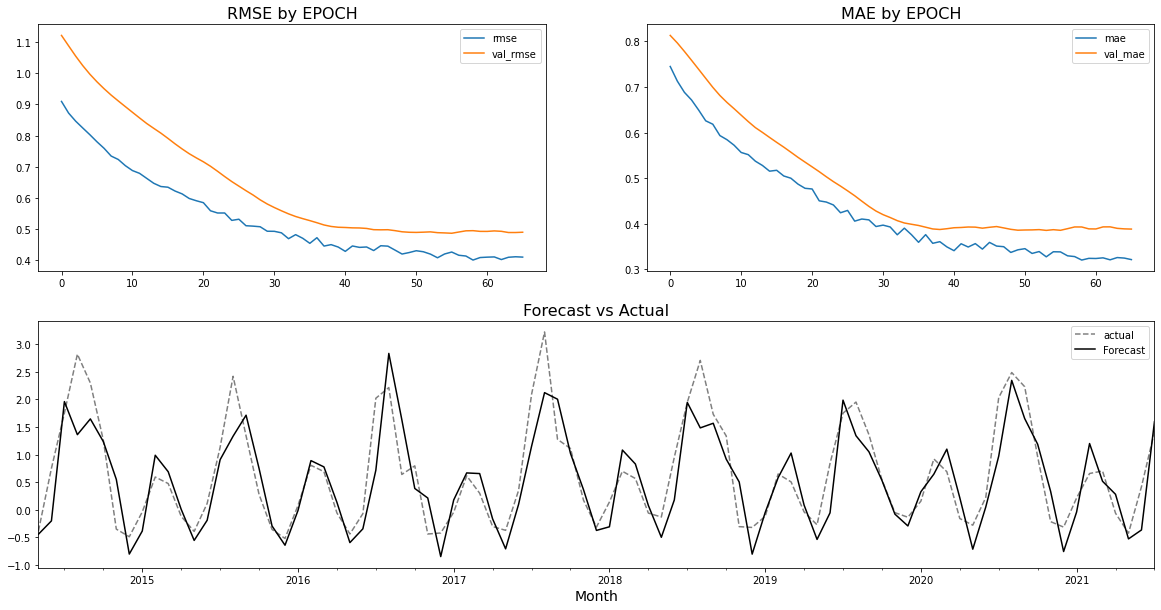

In [82]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [83]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [84]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 304ms/step - loss: 0.9924 - root_mean_squared_error: 0.9962 - mean_absolute_error: 0.8124 - val_loss: 3.0911 - val_root_mean_squared_error: 1.7581 - val_mean_absolute_error: 1.6335
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 0.9065 - root_mean_squared_error: 0.9521 - mean_absolute_error: 0.7732 - val_loss: 2.8096 - val_root_mean_squared_error: 1.6762 - val_mean_absolute_error: 1.5427
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8320 - root_mean_squared_error: 0.9122 - mean_absolute_error: 0.7390 - val_loss: 2.5231 - val_root_mean_squared_error: 1.5884 - val_mean_absolute_error: 1.4441
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.7636 - root_mean_squared_error: 0.8739 - mean_absolute_error: 0.7083 - val_loss: 2.2297 - val_root_mean_squared_error: 1.4932 - val_mean_absolute_error: 1.3347
Epoch 5/100
4/4 [==============================] - 0s 21ms/step

In [85]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.3003 - root_mean_squared_error: 1.1403 - mean_absolute_error: 0.9833


[1.300289511680603, 1.1403024196624756, 0.9832766652107239]

(20, 1)


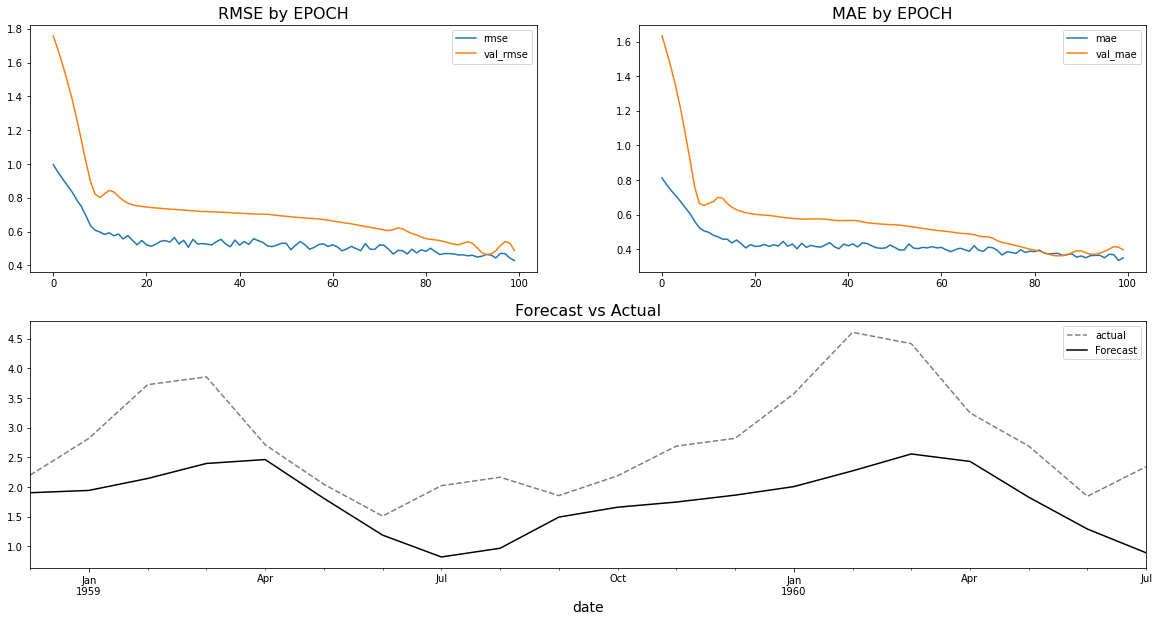

In [86]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

Epoch 1/100
33/33 [==============================] - 5s 38ms/step - loss: 0.9161 - root_mean_squared_error: 0.9571 - mean_absolute_error: 0.7888 - val_loss: 0.6528 - val_root_mean_squared_error: 0.8080 - val_mean_absolute_error: 0.6341
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.8054 - root_mean_squared_error: 0.8974 - mean_absolute_error: 0.7117 - val_loss: 0.6030 - val_root_mean_squared_error: 0.7765 - val_mean_absolute_error: 0.5915
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.7497 - root_mean_squared_error: 0.8658 - mean_absolute_error: 0.6793 - val_loss: 0.5581 - val_root_mean_squared_error: 0.7471 - val_mean_absolute_error: 0.5679
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6824 - root_mean_squared_error: 0.8261 - mean_absolute_error: 0.6431 - val_loss: 0.4992 - val_root_mean_squared_error: 0.7066 - val_mean_absolute_error: 0.5373
Epoch 5/100
33/33 [==============================] - 0s 7ms

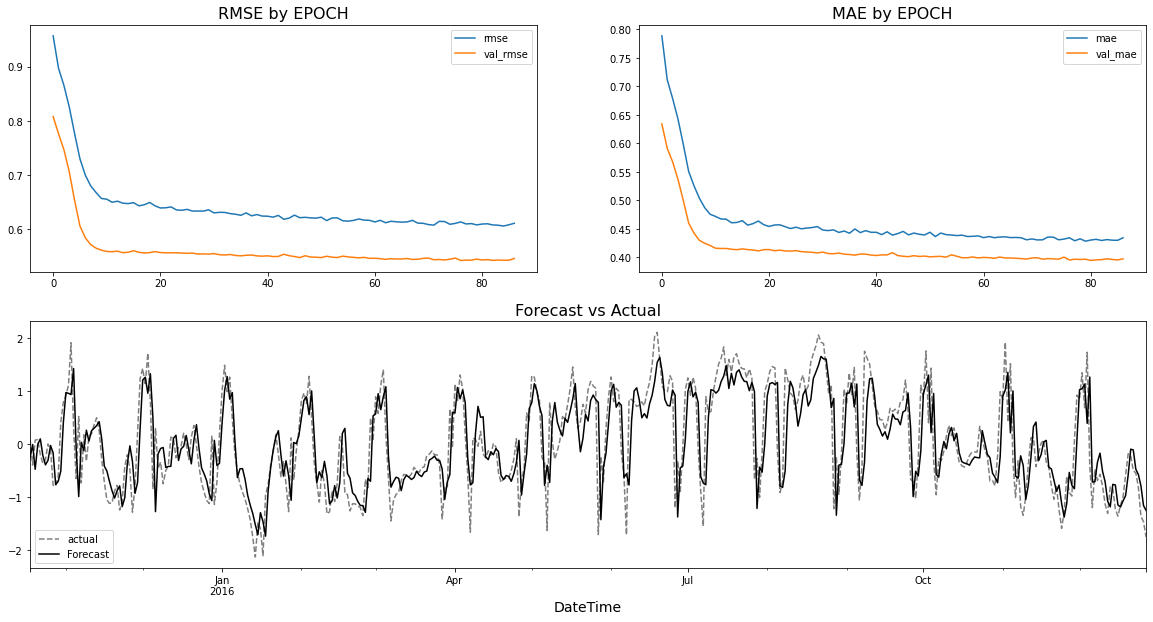

In [87]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 4s 123ms/step - loss: 0.9973 - root_mean_squared_error: 0.9987 - mean_absolute_error: 0.8210 - val_loss: 1.5475 - val_root_mean_squared_error: 1.2440 - val_mean_absolute_error: 0.8724
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.9629 - root_mean_squared_error: 0.9813 - mean_absolute_error: 0.8045 - val_loss: 1.5162 - val_root_mean_squared_error: 1.2314 - val_mean_absolute_error: 0.8687
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9517 - root_mean_squared_error: 0.9755 - mean_absolute_error: 0.8010 - val_loss: 1.4816 - val_root_mean_squared_error: 1.2172 - val_mean_absolute_error: 0.8637
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.9353 - root_mean_squared_error: 0.9671 - mean_absolute_error: 0.7966 - val_loss: 1.4471 - val_root_mean_squared_error: 1.2029 - val_mean_absolute_error: 0.8581
Epoch 5/100
7/7 [==============================] - 0s 8ms/step 

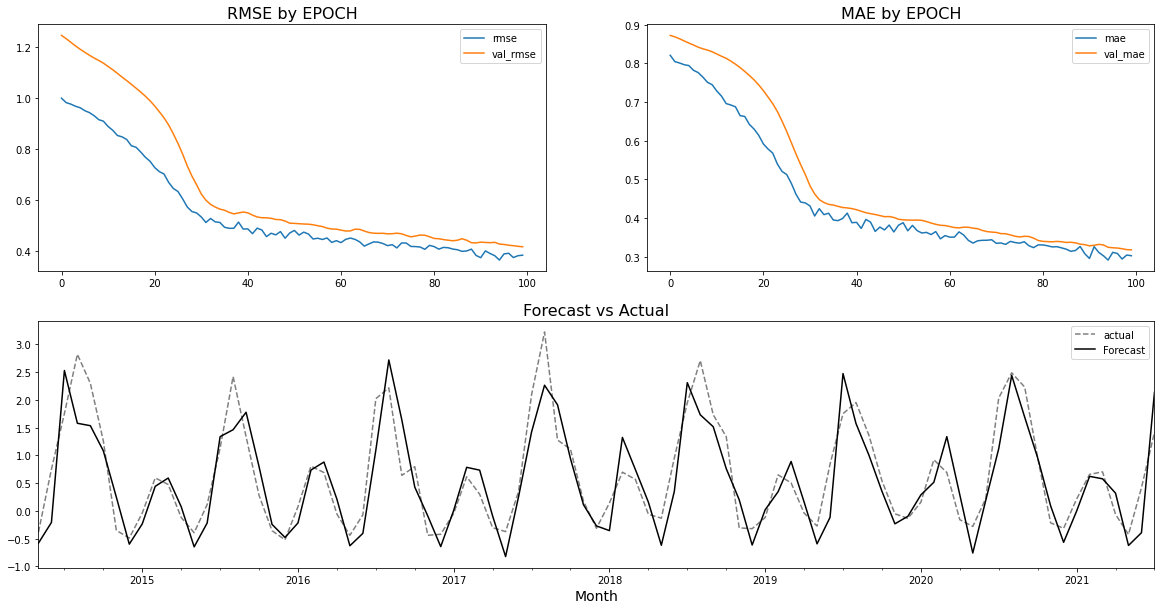

In [88]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [89]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [90]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 20s 2s/step - loss: 0.7353 - root_mean_squared_error: 0.8575 - mean_absolute_error: 0.6934 - val_loss: 1.9861 - val_root_mean_squared_error: 1.4093 - val_mean_absolute_error: 1.2471
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.5575 - root_mean_squared_error: 0.7467 - mean_absolute_error: 0.6010 - val_loss: 1.4917 - val_root_mean_squared_error: 1.2214 - val_mean_absolute_error: 1.0253
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.4376 - root_mean_squared_error: 0.6615 - mean_absolute_error: 0.5298 - val_loss: 1.0584 - val_root_mean_squared_error: 1.0288 - val_mean_absolute_error: 0.8136
Epoch 4/100
4/4 [==============================] - 0s 36ms/step - loss: 0.3314 - root_mean_squared_error: 0.5757 - mean_absolute_error: 0.4614 - val_loss: 0.7213 - val_root_mean_squared_error: 0.8493 - val_mean_absolute_error: 0.6266
Epoch 5/100
4/4 [==============================] - 0s 21ms/step -

In [91]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 25ms/step - loss: 2.3252 - root_mean_squared_error: 1.5249 - mean_absolute_error: 1.3815


[2.3251702785491943, 1.524850845336914, 1.3815085887908936]

(20, 1)


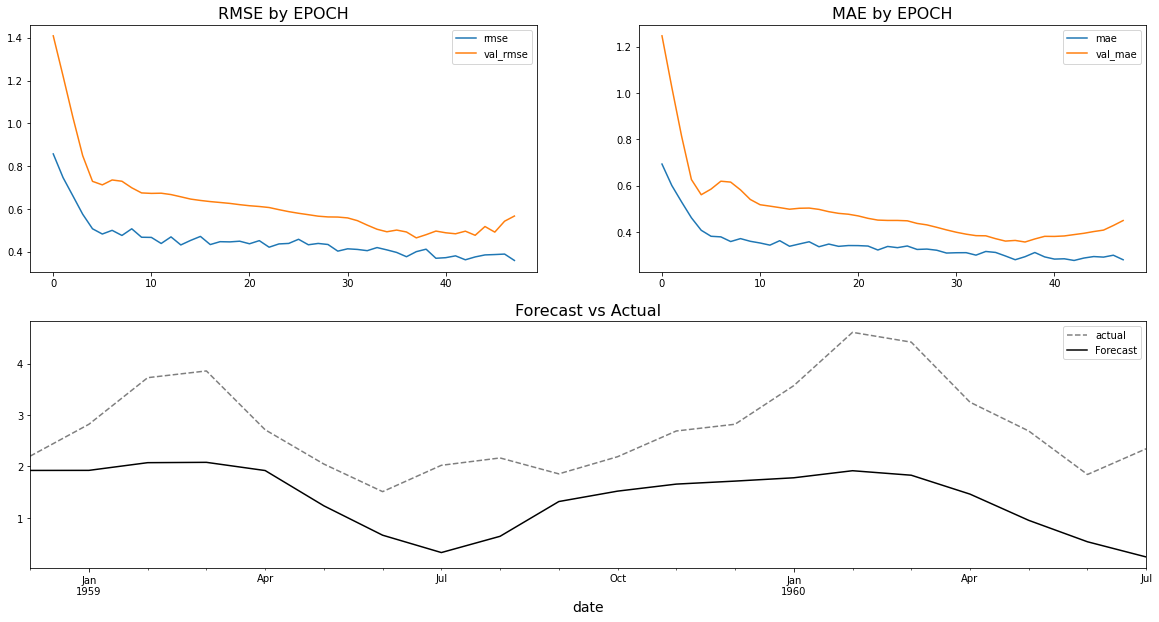

In [92]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [93]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 10s 71ms/step - loss: 0.8038 - root_mean_squared_error: 0.8965 - mean_absolute_error: 0.7190 - val_loss: 0.5101 - val_root_mean_squared_error: 0.7142 - val_mean_absolute_error: 0.5193
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.6145 - root_mean_squared_error: 0.7839 - mean_absolute_error: 0.5851 - val_loss: 0.4068 - val_root_mean_squared_error: 0.6378 - val_mean_absolute_error: 0.4686
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.5091 - root_mean_squared_error: 0.7135 - mean_absolute_error: 0.5240 - val_loss: 0.3341 - val_root_mean_squared_error: 0.5780 - val_mean_absolute_error: 0.4314
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4721 - root_mean_squared_error: 0.6871 - mean_absolute_error: 0.5045 - val_loss: 0.3265 - val_root_mean_squared_error: 0.5714 - val_mean_absolute_error: 0.4296
Epoch 5/100
33/33 [==============================] - 0s 

In [94]:
x_test_dw.shape

(437, 5, 1)

In [95]:
model_dw_bd.predict(x_test_dw).shape

(437, 1)

(437, 1)


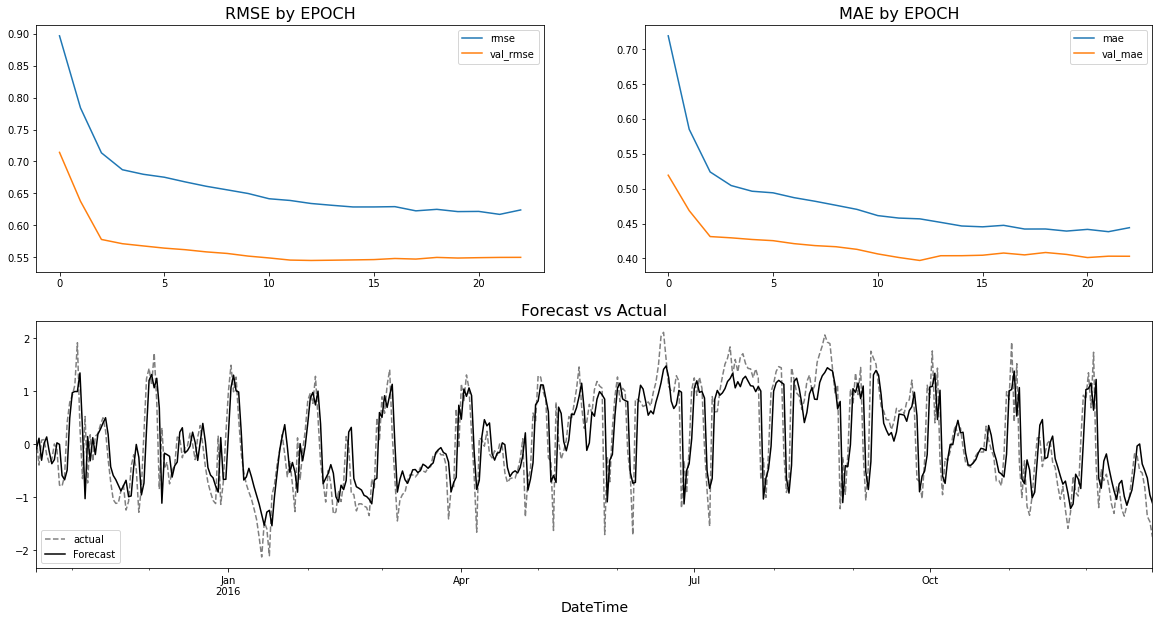

In [96]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 10s 253ms/step - loss: 0.9661 - root_mean_squared_error: 0.9829 - mean_absolute_error: 0.8074 - val_loss: 1.4695 - val_root_mean_squared_error: 1.2122 - val_mean_absolute_error: 0.8624
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.8914 - root_mean_squared_error: 0.9442 - mean_absolute_error: 0.7771 - val_loss: 1.3574 - val_root_mean_squared_error: 1.1651 - val_mean_absolute_error: 0.8491
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.8339 - root_mean_squared_error: 0.9132 - mean_absolute_error: 0.7504 - val_loss: 1.2503 - val_root_mean_squared_error: 1.1182 - val_mean_absolute_error: 0.8320
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.7955 - root_mean_squared_error: 0.8919 - mean_absolute_error: 0.7244 - val_loss: 1.1587 - val_root_mean_squared_error: 1.0764 - val_mean_absolute_error: 0.8093
Epoch 5/100
7/7 [==============================] - 0s 16ms/ste

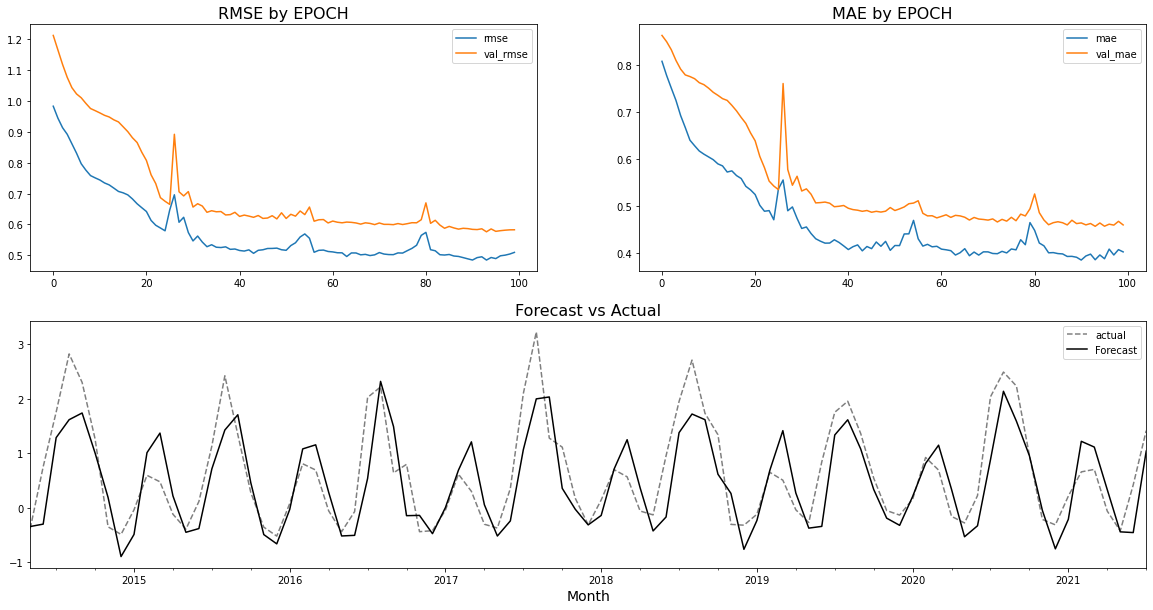

In [97]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [104]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [105]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 232ms/step - loss: 0.8993 - root_mean_squared_error: 0.9483 - mean_absolute_error: 0.7688 - val_loss: 2.8526 - val_root_mean_squared_error: 1.6890 - val_mean_absolute_error: 1.5509
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.8513 - root_mean_squared_error: 0.9227 - mean_absolute_error: 0.7458 - val_loss: 2.6916 - val_root_mean_squared_error: 1.6406 - val_mean_absolute_error: 1.4932
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8117 - root_mean_squared_error: 0.9009 - mean_absolute_error: 0.7268 - val_loss: 2.5191 - val_root_mean_squared_error: 1.5872 - val_mean_absolute_error: 1.4272
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.7715 - root_mean_squared_error: 0.8783 - mean_absolute_error: 0.7072 - val_loss: 2.3383 - val_root_mean_squared_error: 1.5291 - val_mean_absolute_error: 1.3524
Epoch 5/100
4/4 [==============================] - 0s 17ms/step

In [106]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 30ms/step - loss: 1.6634 - root_mean_squared_error: 1.2897 - mean_absolute_error: 1.0278


[1.6633689403533936, 1.2897167205810547, 1.0278111696243286]

(20, 1)


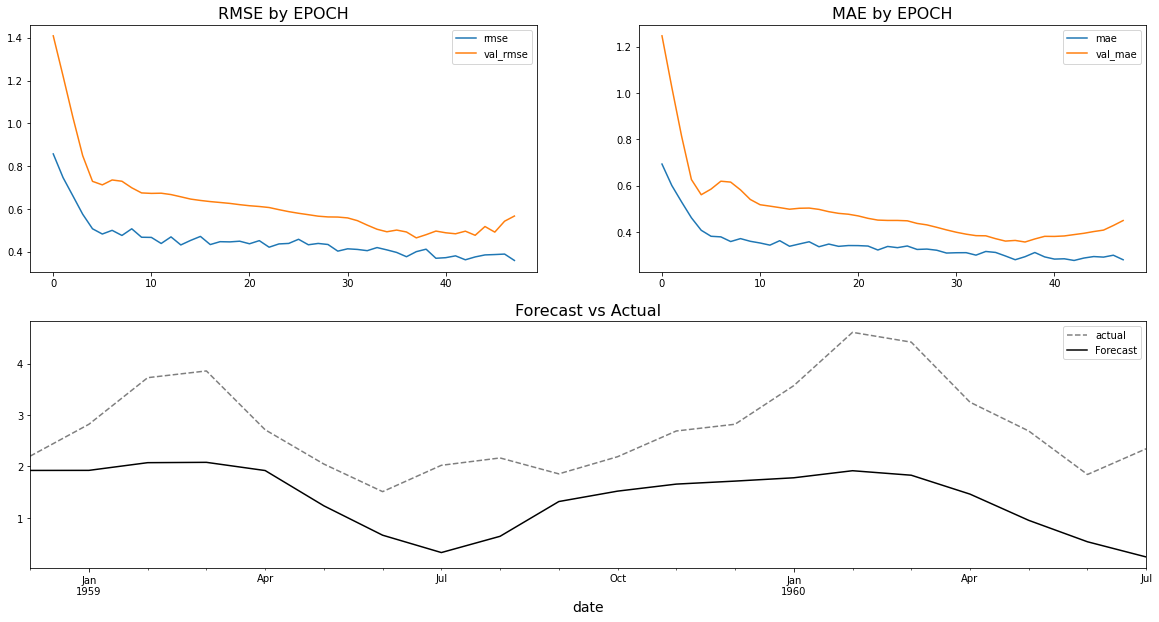

In [107]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

Epoch 1/100
33/33 [==============================] - 4s 27ms/step - loss: 0.9550 - root_mean_squared_error: 0.9772 - mean_absolute_error: 0.8083 - val_loss: 0.7297 - val_root_mean_squared_error: 0.8542 - val_mean_absolute_error: 0.6875
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.9018 - root_mean_squared_error: 0.9496 - mean_absolute_error: 0.7721 - val_loss: 0.7064 - val_root_mean_squared_error: 0.8405 - val_mean_absolute_error: 0.6646
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.8829 - root_mean_squared_error: 0.9396 - mean_absolute_error: 0.7587 - val_loss: 0.6915 - val_root_mean_squared_error: 0.8316 - val_mean_absolute_error: 0.6568
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.8643 - root_mean_squared_error: 0.9297 - mean_absolute_error: 0.7481 - val_loss: 0.6764 - val_root_mean_squared_error: 0.8224 - val_mean_absolute_error: 0.6470
Epoch 5/100
33/33 [==============================] - 0s 7ms

ValueError: Length of values (2185) does not match length of index (437)

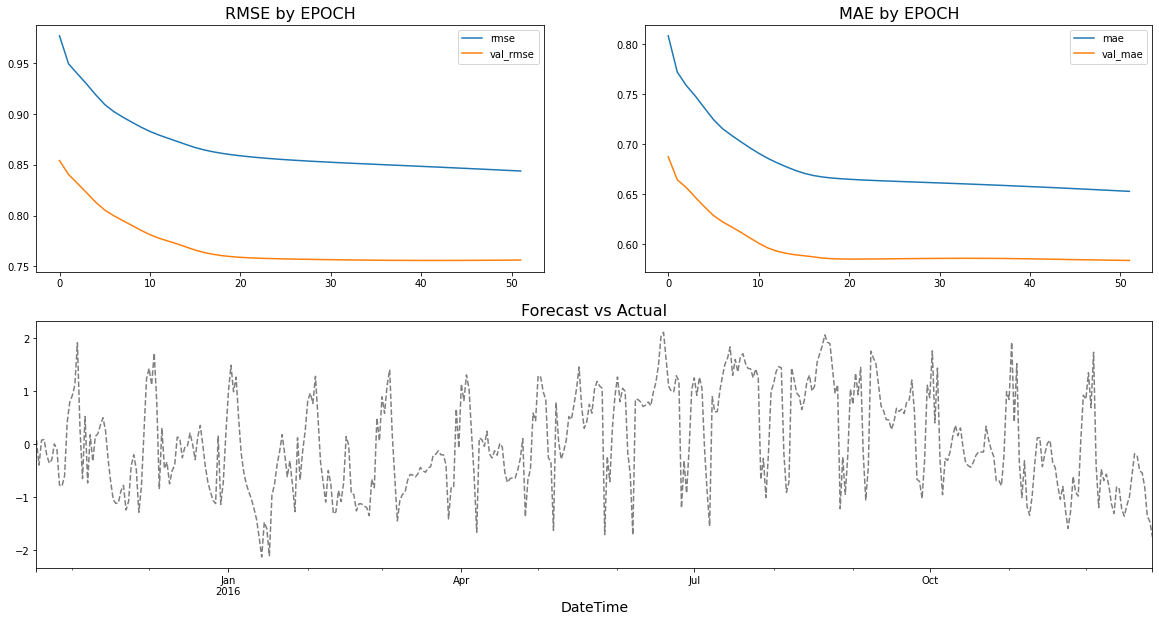

In [108]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_td, x_test_dw, y_test_dw, test_dw.index, history_dw_td)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 4s 163ms/step - loss: 1.0053 - root_mean_squared_error: 1.0027 - mean_absolute_error: 0.8237 - val_loss: 1.5823 - val_root_mean_squared_error: 1.2579 - val_mean_absolute_error: 0.8776
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 0.9962 - root_mean_squared_error: 0.9981 - mean_absolute_error: 0.8192 - val_loss: 1.5782 - val_root_mean_squared_error: 1.2563 - val_mean_absolute_error: 0.8765
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 0.9942 - root_mean_squared_error: 0.9971 - mean_absolute_error: 0.8190 - val_loss: 1.5697 - val_root_mean_squared_error: 1.2529 - val_mean_absolute_error: 0.8742
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.9930 - root_mean_squared_error: 0.9965 - mean_absolute_error: 0.8193 - val_loss: 1.5605 - val_root_mean_squared_error: 1.2492 - val_mean_absolute_error: 0.8719
Epoch 5/100
7/7 [==============================] - 0s 12ms/step

ValueError: Length of values (435) does not match length of index (87)

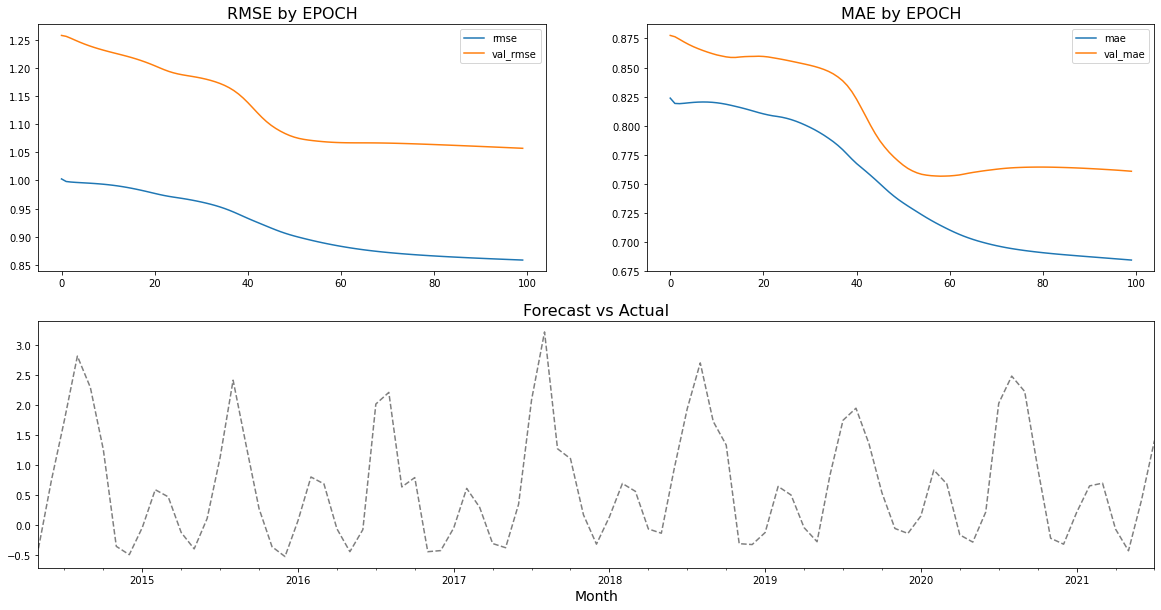

In [109]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_td, x_test_en, y_test_en, test_en.index, history_en_td)

## Compare

In [110]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 22ms/step - loss: 1.6634 - root_mean_squared_error: 1.2897 - mean_absolute_error: 1.0278


,MSE,RMSE,MAE
GRU,0.650213,0.806358,0.646780
SimpleRNN,0.772813,0.879098,0.731966
LSTM,1.180706,1.086603,0.861827
Deep LSTM,1.300290,1.140302,0.983277
TimeDistributed,1.663369,1.289717,1.027811
Bidirectional,2.325170,1.524851,1.381509


In [111]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 22ms/step - loss: 3.5074 - root_mean_squared_error: 1.8728 - mean_absolute_error: 1.5670


,MSE,RMSE,MAE
LSTM,0.891230,0.944050,0.765032
SimpleRNN,1.136925,1.066267,0.878743
GRU,1.175688,1.084291,0.948793
Deep LSTM,1.192208,1.091883,0.880100
Bidirectional,1.667942,1.291488,1.072728
TimeDistributed,3.507415,1.872809,1.566972


In [112]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 22ms/step - loss: 11.2710 - root_mean_squared_error: 3.3572 - mean_absolute_error: 3.2232


,MSE,RMSE,MAE
SimpleRNN,0.854677,0.924487,0.760059
GRU,2.156728,1.468580,1.294036
LSTM,2.324697,1.524696,1.401025
Bidirectional,2.332438,1.527232,1.434140
Deep LSTM,2.441557,1.562548,1.468923
TimeDistributed,11.271019,3.357234,3.223172


## There is more

Using Keras Model API 

In [113]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout, Input,
                Activation)

In [114]:
def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(None, None, train.shape[1]))
    lstm1 = LSTM(units)(input_data)
    dropout_1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(units)(dropout_1)
    # dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1, )(lstm2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

In [115]:
x_train_air.shape

(102, 5, 1)

In [116]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

ValueError: Input 0 of layer "lstm_25" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, None, None, 5)

### Air Passenger

In [117]:
history_a_m = train_model(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

NameError: name 'model_a_m' is not defined

In [118]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

NameError: name 'model_a_m' is not defined

In [119]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)

NameError: name 'model_a_m' is not defined